In [1]:
!ls

SupplementaryTable_gm12878weights.txt   deltasvm_script.tar.gz
SupplementaryTable_hepg2weights.txt     gkmsvm_weights_hg19_DukeDnase
SupplementaryTable_k562weights.txt      gkmsvm_weights_hg19_DukeDnase.tar.bz2
SupplementaryTable_melanp300weights.txt gkmsvm_weights_hg19_UwDnase
SupplementaryTable_mmliverweights.txt   gkmsvm_weights_hg19_UwDnase.tar.bz2
SupplementaryTable_mmliverweights.txt.1 gkmsvm_weights_mm9_UwDnase
Untitled.ipynb                          gkmsvm_weights_mm9_UwDnase.tar.bz2
deltasvm_script


In [3]:
in_kmers_scores_file = "SupplementaryTable_gm12878weights.txt"

In [2]:
!head SupplementaryTable_gm12878weights.txt

kmer	revcomp	weight
AAAAAAAAAA	TTTTTTTTTT	0.950214
AAAAAAAAAC	GTTTTTTTTT	0.691027
AAAAAAAAAG	CTTTTTTTTT	0.131538
AAAAAAAAAT	ATTTTTTTTT	0.309418
AAAAAAAACA	TGTTTTTTTT	-0.0408372
AAAAAAAACC	GGTTTTTTTT	0.728739
AAAAAAAACG	CGTTTTTTTT	0.368697
AAAAAAAACT	AGTTTTTTTT	0.457357
AAAAAAAAGA	TCTTTTTTTT	-0.125938


In [326]:
fd = open("summary.json")

In [345]:
class Substitution:
    def __init__(self, seq, pos, subs):
        self.seq = seq
        self.pos = pos
        self.subs = subs
    
    @property
    def ref(self):
        return self.seq[self.pos]



class WrongSVMDeltaFileFormat(Exception):
    def __init__(self,*args,**kwargs):
        super().__init__(self,*args,**kwargs)
        

def kmerrev(kmer, transtab=str.maketrans("ATGC", "TACG")):
    return kmer.translate(transtab)
    
class SVMDeltaFeaturizer:
    def __init__(self, kmer_size, kmer_dt):
        self.kmer_size = kmer_size
        self.kmer_dt = kmer_dt
    
    
    @staticmethod
    def kmer_file_to_dt(kmer_fn):
        kmers_scores = {}
        kmer_size = None
        with open(kmer_fn, "r") as kmer_fd:
            header = kmer_fd.readline() # pass header
            format2=False
            if len(header.split()) == 2:
                kmer_fd.seek(0)
                format2=True
                
            for line in kmer_fd:
                if not format2:
                    kmer, rckmer, weight = line.split()
                else:
                    kmer, weight = line.split()
                    rckmer = kmerrev(kmer) 
                weight = float(weight)
                if kmer_size is None:
                    kmer_size = len(kmer)
                if len(kmer) != kmer_size or len(rckmer) != kmer_size:
                    raise WrongSVMDeltaFileFormat("Kmers sizes must be equal")
                
                kmers_scores[kmer] = weight
                kmers_scores[rckmer] = weight
        return kmers_scores, kmer_size
    
    @classmethod
    def from_kmer_file(cls, kmer_fn):
        dt, kmer_size = SVMDeltaFeaturizer.kmer_file_to_dt(kmer_fn)
        return cls(kmer_size, dt)
    
    def get_kmer_score(self, kmer):
        return self.dt[kmer]
    
    def get_seq_score(self, seq):
        score = 0
        for i in range(0, len(seq)-self.kmer_size + 1):
            kmer = seq[i:(i + self.kmer_size)]
            score += self.kmer_dt[kmer]
        return score
    
    def get_subs_score(self, subs):
        min_pos = max((subs.pos - self.kmer_size + 1), 0)
        seq = subs.seq[min_pos:(subs.pos + self.kmer_size)]
        subs_pos = subs.pos - min_pos
        seq_changed = seq[:subs_pos] + subs.subs + seq[subs_pos+1:]
        
        score = 0
        for i in range(0, len(seq)-self.kmer_size + 1):
            kmer = seq[i:(i + self.kmer_size)]
            alt = seq_changed[i:(i + self.kmer_size)]
            
            kmer_score = self.kmer_dt[kmer]
            alt_score = self.kmer_dt[alt]
            diff = kmer_score - alt_score
            score += diff
        
        return self.get_seq_score(seq) - self.get_seq_score(seq_changed)

In [116]:
svmdeltafeat = SVMDeltaFeaturizer.from_kmer_file(in_kmers_scores_file)

In [117]:
subs = Substitution("GTCTCTGCAACAAAGACAGA", subs="A", pos=10)

In [126]:
import glob
import os

In [538]:
summary = {
    "GM12878_DHS": "supplementary/SupplementaryTable_gm12878weights.txt",
    "Melan_EP300": "supplementary/SupplementaryTable_melanp300weights.txt",
    "Mouse_Liver_DHS_plus_H3K4me1": "supplementary/SupplementaryTable_mmliverweights.txt",
    "K562_DHS_plus_H3K4me1": "supplementary/SupplementaryTable_k562weights.txt",
    "HepG2_DHS_plus_H3K4me1": "supplementary/SupplementaryTable_hepg2weights.txt",
    
} 

summary.update({"uwdnase" + os.path.basename(x).split("_")[1] : x for x in glob.glob("gkmsvm_weights_hg19_UwDnase/*")})
summary.update({"dukednase" + os.path.basename(x).split("_")[1] : x for x in glob.glob("gkmsvm_weights_hg19_DukeDnase/*")})
import json
with open("summary.json", 'w') as out_file:
    json.dump(summary, out_file, indent=4)

{'GM12878_DHS': 'supplementary/SupplementaryTable_gm12878weights.txt',
 'HepG2_DHS_plus_H3K4me1': 'supplementary/SupplementaryTable_hepg2weights.txt',
 'K562_DHS_plus_H3K4me1': 'supplementary/SupplementaryTable_k562weights.txt',
 'Melan_EP300': 'supplementary/SupplementaryTable_melanp300weights.txt',
 'Mouse_Liver_DHS_plus_H3K4me1': 'supplementary/SupplementaryTable_mmliverweights.txt',
 'dukednaseDukeDnase8988tAln': 'gkmsvm_weights_hg19_DukeDnase/tup2_DukeDnase8988tAln_500_nc30_np_top10k_nsr1x1_gkm_1_10_6_3_weights.out',
 'dukednaseDukeDnaseA549Aln': 'gkmsvm_weights_hg19_DukeDnase/tup2_DukeDnaseA549Aln_500_nc30_np_top10k_nsr1x1_gkm_1_10_6_3_weights.out',
 'dukednaseDukeDnaseAdultcd4th0Aln': 'gkmsvm_weights_hg19_DukeDnase/tup2_DukeDnaseAdultcd4th0Aln_500_nc30_np_top10k_nsr1x1_gkm_1_10_6_3_weights.out',
 'dukednaseDukeDnaseAdultcd4th1Aln': 'gkmsvm_weights_hg19_DukeDnase/tup2_DukeDnaseAdultcd4th1Aln_500_nc30_np_top10k_nsr1x1_gkm_1_10_6_3_weights.out',
 'dukednaseDukeDnaseAosmcSerumfreeAl

In [142]:
import pandas as pd

{'F9': '../challenge_F9.tsv',
 'GP1BB': '../challenge_GP1BB.tsv',
 'HBB': '../challenge_HBB.tsv',
 'HBG1': '../challenge_HBG1.tsv',
 'HNF4A': '../challenge_HNF4A.tsv',
 'IRF4': '../challenge_IRF4.tsv',
 'IRF6': '../challenge_IRF6.tsv',
 'LDLR': '../challenge_LDLR.tsv',
 'MSMB': '../challenge_MSMB.tsv',
 'MYCrs6983267': '../challenge_MYCrs6983267.tsv',
 'PKLR': '../challenge_PKLR.tsv',
 'SORT1': '../challenge_SORT1.tsv',
 'TERT-GBM': '../challenge_TERT-GBM.tsv',
 'TERT-HEK293T': '../challenge_TERT-HEK293T.tsv',
 'ZFAND3': '../challenge_ZFAND3.tsv'}

In [540]:
regulator = "F9"

In [541]:
import Bio.SeqIO as SeqIO

In [542]:
class Regulator:
    def __init__(self, name, chrom, seq, start, end):
        self.name = name
        self.chrom = chrom
        self.seq = seq
        self.start = start
        self.end = end
        
    def __repr__(self):
        return f"|{self.name}: <{self.chrom}, {self.start}:{self.end}>|"

In [560]:

PROMOTORS_FILE = "promoters.fa"
ENHANCERS_FILE = "enhancers.fa"
regulators = []
for rec in SeqIO.parse(PROMOTORS_FILE, format="fasta"):
    name, chrom_start_end = rec.name.split("::")
    chrom, start_end = chrom_start_end.split(":")
    start, end = start_end.split("-")
    start, end = int(start), int(end)
    reg = Regulator(name, chrom, str(rec.seq).upper(), start, end)
    regulators.append(reg)
    
for rec in SeqIO.parse(ENHANCERS_FILE, format="fasta"):
    name, chrom_start_end = rec.name.split("::")
    chrom, start_end = chrom_start_end.split(":")
    start, end = start_end.split("-")
    start, end = int(start), int(end)
    
    reg = Regulator(name, chrom, str(rec.seq).upper(), start, end)
    regulators.append(reg)
    
    

In [561]:
for reg in regulators:
    if reg.name == "MYC_rs6983267":
        reg.name = "MYCrs6983267"
    if reg.name == "HNF4A_P2":
        reg.name = "HNF4A"
    if reg.name == "TERT_GBM":
        reg.name = "TERT-GBM"
    if reg.name == "TERT_HEK293T":
        reg.name = "TERT-HEK293T"

In [562]:
test_paths = {os.path.splitext(os.path.basename(x).split("_")[-1])[0] : x for x in glob.glob("../challenge_*")}
dataframes = []
for reg in regulators:
    df = pd.read_table(test_paths[reg.name], comment="#", header=None, names=["Chrom", "Pos", "Ref", "Alt",
                                                                         "Value",
                                                                         "Confidence"])
    df['Regulator'] = reg.name
    dataframes.append(df)
test_data = pd.concat(dataframes)

In [563]:
train_paths = {os.path.splitext(os.path.basename(x).split("_")[-1])[0] : x for x in glob.glob("../release_*")}
dataframes = []
for reg in regulators:
    df = pd.read_table(train_paths[reg.name], comment="#", header=None, names=["Chrom", "Pos", "Ref", "Alt",
                                                                         "Value",
                                                                         "Confidence"])
    df['Regulator'] = reg.name
    dataframes.append(df)
train_data = pd.concat(dataframes)

In [564]:
regulators_dt = {reg.name : reg for reg in regulators}

In [565]:
for reg in regulators:
    reg_data = train_data.query(f'Regulator == "{reg.name}"')


In [566]:
import json
with open("summary.json", 'r') as in_file:
    svmdelta_feature_summary = json.load(in_file)

In [567]:
all_subs = []
for ind, row in train_data.iterrows():

    regulator = regulators_dt[row.Regulator]
    if row.Pos > regulator.end: 
        all_subs.append(None)
        continue

    subs = Substitution(seq=regulator.seq, pos=row.Pos - regulator.start - 1, subs=row.Alt)
    all_subs.append(subs)
    #assert(subs.ref == row.Ref) for some letters references are different

In [568]:
len(svmdelta_feature_summary)

227

In [569]:
kmerdelta_cagi2018_features = "kmerdelta_cagi2018"
try:
    os.mkdir(kmerdelta_cagi2018_features)
except FileExistsError:
    pass
    
for key, value in svmdelta_feature_summary.items():
    print(key)
    out_path = os.path.join(kmerdelta_cagi2018_features, f"{key}_feature.txt")
    featurizer = SVMDeltaFeaturizer.from_kmer_file(value)
    with open(out_path, "w") as out_file:
        for subs in all_subs:
            if subs is not None:
                score = featurizer.get_subs_score(subs)
            else:
                score = 0.0
            out_file.write(f"{score:.02f}\n")

GM12878_DHS
Melan_EP300
Mouse_Liver_DHS_plus_H3K4me1
K562_DHS_plus_H3K4me1
HepG2_DHS_plus_H3K4me1
uwdnaseUwDnaseTh1Aln
uwdnaseUwDnaseHpdlfAln
uwdnaseUwDnaseH7esDiffa9dAln
uwdnaseUwDnaseHbvpAln
uwdnaseUwDnaseAoafAln
uwdnaseUwDnaseCd34mobilizedAln
uwdnaseUwDnaseNb4Aln
uwdnaseUwDnaseHffmycAln
uwdnaseUwDnaseCd4naivewb78495824Aln
uwdnaseUwDnaseK562Znf2c10c5Aln
uwdnaseUwDnaseHipeAln
uwdnaseUwDnaseHepg2Aln
uwdnaseUwDnaseHmvecdblneoAln
uwdnaseUwDnaseK562Znff41b2Aln
uwdnaseUwDnaseTregwb78495824Aln
uwdnaseUwDnaseNhdfadAln
uwdnaseUwDnaseRptecAln
uwdnaseUwDnaseHmvecdbladAln
uwdnaseUwDnaseHl60Aln
uwdnaseUwDnaseNhekAln
uwdnaseUwDnaseNhlfAln
uwdnaseUwDnaseHcfAln
uwdnaseUwDnaseHacAln
uwdnaseUwDnaseH7esDiffa2dAln
uwdnaseUwDnaseTregwb83319432Aln
uwdnaseUwDnaseHmvecdadAln
uwdnaseUwDnaseTh2wb33676984Aln
uwdnaseUwDnaseHelas3Aln
uwdnaseUwDnaseGm12878Aln
uwdnaseUwDnaseTh1wb33676984Aln
uwdnaseUwDnaseMscAln
uwdnaseUwDnaseSkmcAln
uwdnaseUwDnaseK562Znfe103c6Aln
uwdnaseUwDnaseHaeAln
uwdnaseUwDnaseH1hescAln
uwdnas

In [570]:
all_subs = []
for ind, row in test_data.iterrows():

    regulator = regulators_dt[row.Regulator]
    if row.Pos > regulator.end: 
        all_subs.append(None)
        continue

    subs = Substitution(seq=regulator.seq, pos=row.Pos - regulator.start - 1, subs=row.Alt)
    all_subs.append(subs)

In [571]:
kmerdelta_cagi2018_features_test = "kmerdelta_cagi2018_test"
try:
    os.mkdir(kmerdelta_cagi2018_features)
except FileExistsError:
    pass
    
for key, value in svmdelta_feature_summary.items():
    print(key)
    out_path = os.path.join(kmerdelta_cagi2018_features_test, f"{key}_feature.txt")
    featurizer = SVMDeltaFeaturizer.from_kmer_file(value)
    with open(out_path, "w") as out_file:
        for subs in all_subs:
            if subs is not None:
                score = featurizer.get_subs_score(subs)
            else:
                score = 0.0
            out_file.write(f"{score:.02f}\n")

GM12878_DHS
Melan_EP300
Mouse_Liver_DHS_plus_H3K4me1
K562_DHS_plus_H3K4me1
HepG2_DHS_plus_H3K4me1
uwdnaseUwDnaseTh1Aln
uwdnaseUwDnaseHpdlfAln
uwdnaseUwDnaseH7esDiffa9dAln
uwdnaseUwDnaseHbvpAln
uwdnaseUwDnaseAoafAln
uwdnaseUwDnaseCd34mobilizedAln
uwdnaseUwDnaseNb4Aln
uwdnaseUwDnaseHffmycAln
uwdnaseUwDnaseCd4naivewb78495824Aln
uwdnaseUwDnaseK562Znf2c10c5Aln
uwdnaseUwDnaseHipeAln
uwdnaseUwDnaseHepg2Aln
uwdnaseUwDnaseHmvecdblneoAln
uwdnaseUwDnaseK562Znff41b2Aln
uwdnaseUwDnaseTregwb78495824Aln
uwdnaseUwDnaseNhdfadAln
uwdnaseUwDnaseRptecAln
uwdnaseUwDnaseHmvecdbladAln
uwdnaseUwDnaseHl60Aln
uwdnaseUwDnaseNhekAln
uwdnaseUwDnaseNhlfAln
uwdnaseUwDnaseHcfAln
uwdnaseUwDnaseHacAln
uwdnaseUwDnaseH7esDiffa2dAln
uwdnaseUwDnaseTregwb83319432Aln
uwdnaseUwDnaseHmvecdadAln
uwdnaseUwDnaseTh2wb33676984Aln
uwdnaseUwDnaseHelas3Aln
uwdnaseUwDnaseGm12878Aln
uwdnaseUwDnaseTh1wb33676984Aln
uwdnaseUwDnaseMscAln
uwdnaseUwDnaseSkmcAln
uwdnaseUwDnaseK562Znfe103c6Aln
uwdnaseUwDnaseHaeAln
uwdnaseUwDnaseH1hescAln
uwdnas

In [572]:
train_data = train_data.reset_index()

In [573]:
for key, value in svmdelta_feature_summary.items():
    in_path = os.path.join(kmerdelta_cagi2018_features, f"{key}_feature.txt")
    df = pd.read_table(in_path, header=None, names=[key])
    train_data = pd.concat([train_data, df], axis=1)

In [574]:
train_data.shape

(4650, 235)

In [575]:
test_data = test_data.reset_index()
for key, value in svmdelta_feature_summary.items():
    in_path = os.path.join(kmerdelta_cagi2018_features_test, f"{key}_feature.txt")
    df = pd.read_table(in_path, header=None, names=[key])
    test_data = pd.concat([test_data, df], axis=1)

In [576]:
test_data.shape

(13813, 235)

In [577]:
info_columns = ["index", "Chrom", "Pos",  "Ref", "Alt", "Value", "Confidence", "Regulator"]

In [578]:
from sklearn.metrics import roc_auc_score

In [579]:
X = train_data.loc[:, train_data.columns[np.logical_not(train_data.columns.isin(info_columns))]]
Y = train_data.apply(lambda x : 0 if x['Confidence'] < 0.1 else -1 if x['Value'] < 0 else 1,axis=1)

In [580]:
X_test = test_data.loc[:, test_data.columns[np.logical_not(train_data.columns.isin(info_columns))]]
Y_test = test_data.apply(lambda x : 0 if x['Confidence'] < 0.1 else -1 if x['Value'] < 0 else 1,axis=1)

In [581]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [583]:
train_data

,index,Chrom,Pos,Ref,Alt,Value,Confidence,Regulator,GM12878_DHS,Melan_EP300,...,dukednaseDukeDnaseGm13976Aln,dukednaseDukeDnaseT47dEst10nm30mAln,dukednaseDukeDnaseStellateAln,dukednaseDukeDnaseHsmmembAln,dukednaseDukeDnaseUrothelAln,dukednaseDukeDnaseLncapAln,dukednaseDukeDnaseGcbcellAln,dukednaseDukeDnaseProgfibAln,dukednaseDukeDnaseGm20000Aln,dukednaseDukeDnaseGm10266Aln
0,0,X,138612669,T,A,-0.17,0.07,F9,-0.04,-1.46,...,-0.95,-2.73,-0.96,-1.43,-2.09,-2.55,-2.31,-1.72,-0.41,-1.48
1,1,X,138612669,T,C,-0.26,0.24,F9,3.44,1.26,...,-0.95,-0.42,1.92,0.11,-0.79,-0.55,-0.50,0.60,0.61,-0.22
2,2,X,138612669,T,G,0.34,0.05,F9,0.20,-0.61,...,-2.36,-1.24,0.10,-2.04,-1.55,0.65,-2.03,-0.48,-1.47,-2.48
3,3,X,138612670,A,C,0.00,0.00,F9,0.88,-2.57,...,0.62,-2.19,-1.91,-0.15,-2.75,-1.43,1.12,0.61,-1.08,-0.35
4,4,X,138612670,A,G,0.22,0.20,F9,1.09,-1.48,...,0.36,-0.79,-0.60,1.60,-0.53,-0.98,0.49,-0.57,-1.78,-0.94
5,5,X,138612670,A,T,0.12,0.03,F9,1.07,-1.31,...,-3.81,-1.35,-0.72,-1.12,-1.39,-0.49,-3.70,0.66,-3.37,-4.90
6,6,X,138612671,T,A,0.06,0.02,F9,-0.67,-1.37,...,-0.86,-2.00,-1.56,0.31,-0.38,0.59,-1.08,-1.68,0.10,-1.28
7,7,X,138612671,T,C,0.26,0.21,F9,0.03,2.47,...,-0.25,-0.09,-0.15,1.16,-0.02,0.16,-1.08,-0.05,0.34,-0.25
8,8,X,138612671,T,G,0.08,0.01,F9,-2.66,-1.36,...,-0.19,-3.51,-0.50,0.09,-0.23,-1.37,-1.25,-0.67,0.60,-0.96
9,9,X,138612672,C,A,-0.13,0.05,F9,0.55,0.95,...,-0.09,0.48,1.16,0.37,0.85,0.94,0.65,-0.32,0.57,1.00


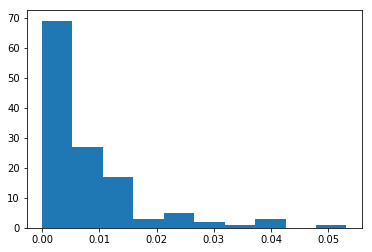

In [584]:
plt.hist(estimator.feature_importances_)
plt.show()

In [601]:
for label in [0, 1, -1]:
    estimator = RandomForestClassifier(n_estimators=550, n_jobs=8, random_state=777)
    estimator.fit(X, Y == label)
    print (f"{label} vs rest")
    
    y_predicted = estimator.predict_proba(X)[:, 1]
    print (roc_auc_score(y_score=y_predicted, y_true= (Y == label) ))
    
    y_predicted = estimator.predict_proba(X_test)[:, 1]
    print (roc_auc_score(y_score=y_predicted, y_true= (Y_test == label) ))

TypeError: __init__() got an unexpected keyword argument 'scale_pos_weight'

In [589]:
import xgboost as xgb

In [616]:
for label in [0, 1, -1]:
    estimator = xgb.XGBClassifier(n_estimators=220, max_depth=3, learning_rate=0.01, n_jobs=-1, seed=777)
    estimator.fit(X, Y == label)
    print (f"{label} vs rest")
    
    
    for ntree in range(1, 221, 20):
        
    #y_predicted = estimator.predict_proba(X)[:, 1]
    #print (roc_auc_score(y_score=y_predicted, y_true= (Y == label) ))

        y_predicted = estimator.predict_proba(X_test, ntree_limit=ntree)[:, 1]
        print (ntree, roc_auc_score(y_score=y_predicted, y_true= (Y_test == label) ))

0 vs rest
1 0.5385073446147275
21 0.5560133778901506
41 0.5618855902397555
61 0.5656998162678977
81 0.5699819732267473
101 0.5726058267086046
121 0.5749048277349618
141 0.5755697306859121
161 0.5753468361416318
181 0.5762209418446775
201 0.5766280956780631
1 vs rest
1 0.5977182116905957
21 0.6523370952122394
41 0.6570016592070851
61 0.6563753283622018
81 0.6560730873149615
101 0.6574453402672471
121 0.6583804018872129
141 0.6573247755455518
161 0.6607903623215055
181 0.6610923870444843
201 0.6611677399955437
-1 vs rest
1 0.5898833509671606
21 0.6448213921105076
41 0.6524412515123749
61 0.6571979131335732
81 0.6590989072089448
101 0.6624215758735494
121 0.663135513853101
141 0.6640468199206563
161 0.6639204511897349
181 0.6634370818293958
201 0.6637816797190736


In [617]:
y_predicted 

array([0.13922934, 0.13922934, 0.13922934, ..., 0.17643335, 0.17243795,
       0.1719042 ], dtype=float32)

In [510]:
import matplotlib.pyplot as plt

In [474]:

print (roc_auc_score(y_score=y_predicted, y_true=Y_test == 1))

0.3878881488195546


In [517]:
X_test.shape

(13813, 128)

In [402]:
from sklearn.model_selection import cross_val_score, KFold

In [459]:
y_predicted

array([[  0., -inf],
       [  0., -inf],
       [  0., -inf],
       ...,
       [  0., -inf],
       [  0., -inf],
       [  0., -inf]])

In [399]:
Y

0       0.07
1       0.24
2       0.05
3       0.00
4       0.20
5       0.03
6       0.02
7       0.21
8       0.01
9       0.05
10      0.02
11      0.02
12      0.01
13      0.03
14      0.56
15      0.01
16      0.01
17      0.02
18      0.01
19      0.00
20      0.04
21      0.01
22      0.08
23      0.04
24      0.05
25      0.12
26      0.00
27      0.06
28      0.08
29      0.00
        ... 
4620    0.00
4621    0.08
4622    0.01
4623    0.01
4624    0.00
4625    0.02
4626    0.01
4627    0.02
4628    0.04
4629    0.00
4630    0.01
4631    0.00
4632    0.04
4633    0.01
4634    0.04
4635    0.01
4636    0.00
4637    0.00
4638    0.00
4639    0.02
4640    0.00
4641    0.03
4642    0.04
4643    0.01
4644    0.01
4645    0.00
4646    0.02
4647    0.00
4648    0.01
4649    0.01
Name: Confidence, Length: 4650, dtype: float64

In [401]:
from sklearn.metrics import mean_absolute_error

In [409]:
kf = KFold(n_splits=5, shuffle=True, random_state=777)


In [417]:
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    estimator = RandomForestRegressor(n_estimators=200, n_jobs=8)
    estimator.fit(X_train, Y_train)
    y_predicted = estimator.predict(X_test)
    print(mean_absolute_error(y_pred=y_predicted, y_true=Y_test))

0.17693158469875409
0.1752108899420472
0.16569069230426084
0.16994082137113187
0.17387412331396201


In [400]:
cross_val_score(estimator=RandomForestRegressor(n_estimators=5), cv=3, n_jobs=8, X=X, y=Y, scoring="neg_mean_squared_error")

array([-0.0779875 , -0.10245837, -0.1019334 ])

In [273]:
regulator.seq

'CCCACTGATGAACTGTGCTGCCACAGTAAATGTAGCCACTATGCCTATCTCCATTCTGAAGATGTGTCACTTCCTGTTTCAGACTCAAATCAGCCACAGTGGCAGAAGCCCACGAAATCAGAGGTGAAATTTAATAATGACCACTGCCCATTCTCTTCACTTGTCCCAAGAGGCCATTGGAAATAGTCCAAAGACCCATTGAGGGAGATGGACATTATTTCCCAGAAGTAAATACAGCTCAGCTTGTACTTTGGTACAACTAATCGACCTTACCACTTTCACAATCTGCTAGCAAAGGTT'

In [279]:
138612766 - regulator.start - 1

142

In [280]:
regulator.seq[142]

'A'